<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/ensemble-methods-for-machine-learning/02-homogeneous-parallel-ensembles/02_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##Random forests

Random forests perform bootstrap sampling to generate a
training subset (exactly like bagging), and then use randomized decision trees as base estimators.

Randomized decision trees are trained using a modified decision-tree learning
algorithm, which introduces randomness when growing our trees. This additional
source of randomness increases ensemble diversity and generally leads to better predictive performance.

Thus, random forests use a modified tree learning algorithm, which first randomly
samples features before creating a decision node. The resulting tree is a randomized
decision tree, which is a new type of base estimator.

In randomized decision-tree learning, we first randomly sample a subset of features(say, $f_2,f_4,f_5$} and then choose the best from among them (which is, say, $f_5$). This
means that the feature $f_3$ is no longer available at this stage of tree learning. Thus, randomization
has inherently forced tree learning to split on a different feature.

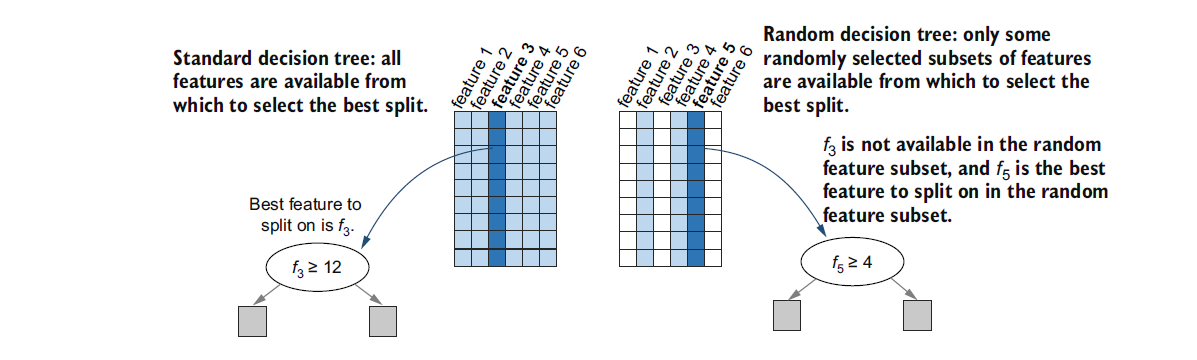

##Setup

In [ ]:
!wget https://github.com/gkunapuli/ensemble-methods-notebooks/raw/master/plot_utils.py

In [3]:
import time
import os
import pickle
import numpy as np

from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from plot_utils import plot_2d_data, plot_2d_classifier

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
random_state = np.random.RandomState(seed=4190)

X, y = make_moons(n_samples=300, noise=.25, random_state=random_state)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

##Random forests with scikit-learn

In [5]:
random_forest_ensemble = RandomForestClassifier(n_estimators=500, 
                                                max_samples=100, 
                                                oob_score=True, 
                                                random_state=random_state)
random_forest_ensemble.fit(x_train, y_train)
y_pred = random_forest_ensemble.predict(x_test)

In [6]:
# let's obtain the OOB score
random_forest_ensemble.oob_score_

0.9502487562189055

In [7]:
# let's see generalization on the test set
accuracy_score(y_test, y_pred)

0.9191919191919192

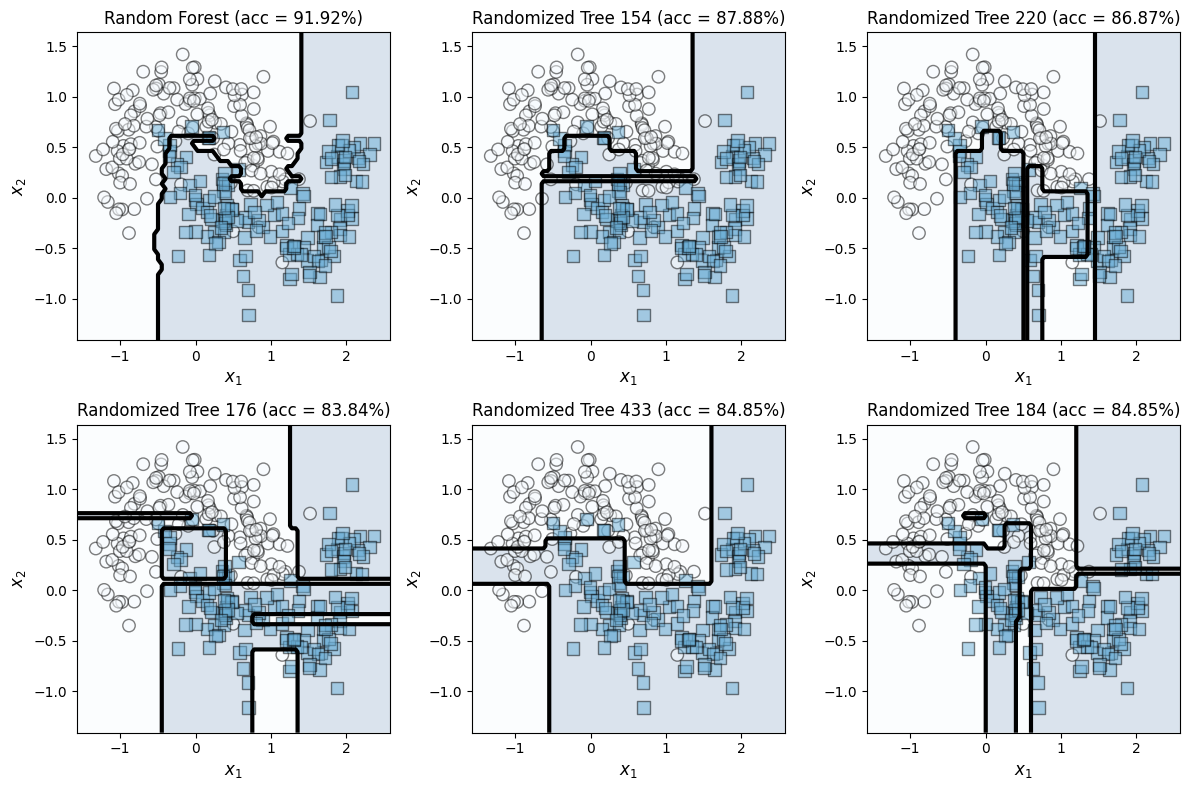

In [8]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
trees_to_plot = np.random.choice(500, 5, replace=True)

title = 'Random Forest (acc = {0:4.2f}%)'.format(accuracy_score(y_test, y_pred)*100)
plot_2d_classifier(ax[0, 0], X, y, colormap='Blues', alpha=0.15, s=80,
                   predict_function=random_forest_ensemble.predict, 
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

for i in range(5):
    r, c = np.divmod(i + 1, 3)  # Get the row and column index of the subplot
    j = trees_to_plot[i]
    
    tst_acc_clf = accuracy_score(y_test, random_forest_ensemble[j].predict(x_test))
    
    # bag = bag_ens.estimators_samples_[j] 
    # X_bag = X[bag, :]
    # y_bag = y[bag]
    
    title = 'Randomized Tree {1} (acc = {0:4.2f}%)'.format(tst_acc_clf*100, j+1)
    plot_2d_classifier(ax[r, c], X, y, colormap='Blues', alpha=0.15, s=80,
                       predict_function=random_forest_ensemble[j].predict, 
                       xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()

##Feature importances

Alternately, you can specify the number of concurrent processes by setting `n_jobs`.

In [ ]:
!rm -rf data
!mkdir data

In [ ]:
# See if the result file for this experiment already exists, and if not, rerun and save a new set of results
if not os.path.exists('data/SeqentialVsParallelBagging.pickle'):
    n_estimator_range = np.arange(50, 525, 50, dtype=int)
    n_range = len(n_estimator_range)
    n_runs = 10

    run_time_seq = np.zeros((n_runs, n_range))
    run_time_par = np.zeros((n_runs, n_range))

    base_estimator = DecisionTreeClassifier(max_depth=5)
    for r in range(n_runs):
        # Split the data randomly into training and test for this run
        X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=100)

        # Learn and evaluate this train/test split for this run with sequential bagging
        for i, n_estimators in enumerate(n_estimator_range):
            start = time.time()
            bag_ens = BaggingClassifier(estimator=base_estimator, 
                                        n_estimators=n_estimators, 
                                        max_samples=100, oob_score=True, n_jobs=1)
            bag_ens.fit(X_trn, y_trn)
            run_time_seq[r, i] = time.time() - start        

         # Learn and evaluate this train/test split for this run
        for i, n_estimators in enumerate(n_estimator_range):
            start = time.time()
            bag_ens = BaggingClassifier(estimator=base_estimator, 
                                        n_estimators=n_estimators, 
                                        max_samples=100, oob_score=True, n_jobs=-1)
            bag_ens.fit(X_trn, y_trn)
            run_time_par[r, i] = time.time() - start
            
    results = (run_time_seq, run_time_par)
    
    with open('./data/SeqentialVsParallelBagging.pickle', 'wb') as result_file:
        pickle.dump(results, result_file)

else:
    with open('./data/SeqentialVsParallelBagging.pickle', 'rb') as result_file:
        (run_time_seq, run_time_par) = pickle.load(result_file) 

Once the sequential vs. parallel results have been loaded/run, plot them.

<ipython-input-40-b47d8a3aa35a>:7: RuntimeWarning: Mean of empty slice
  run_time_seq_mean = np.nanmean(run_time_seq_adj, axis=0)
<ipython-input-40-b47d8a3aa35a>:11: RuntimeWarning: Mean of empty slice
  run_time_par_mean = np.nanmean(run_time_par_adj, axis=0)


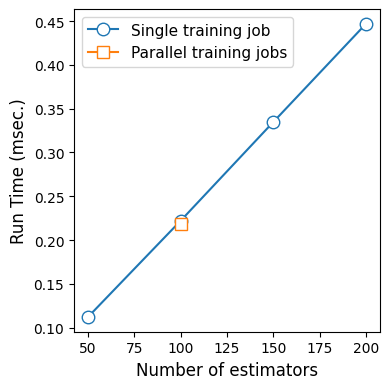

In [ ]:
%matplotlib inline

n_estimator_range = np.arange(50, 525, 50, dtype=int)

run_time_seq_adj = np.copy(run_time_seq)
run_time_seq_adj[run_time_seq > 0.5] = np.nan
run_time_seq_mean = np.nanmean(run_time_seq_adj, axis=0)

run_time_par_adj = np.copy(run_time_par)
run_time_par_adj[run_time_par > 0.3] = np.nan
run_time_par_mean = np.nanmean(run_time_par_adj, axis=0)

fig = plt.figure(figsize=(4, 4))

plt.plot(n_estimator_range, run_time_seq_mean, linewidth=1.5, marker='o', markersize=9, mfc='w');
plt.plot(n_estimator_range[1:], run_time_par_mean[1:], linewidth=1.5, marker='s', markersize=9, mfc='w');
plt.ylabel('Run Time (msec.)', fontsize=12)
plt.xlabel('Number of estimators', fontsize=12)
plt.legend(['Single training job', 'Parallel training jobs'], fontsize=11, loc='upper left');

fig.tight_layout()